In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
from pathlib import Path
os.chdir("/content/drive/My Drive/Classroom/projects/BERT")
!ls -l

total 1247
drwx------ 2 root root   4096 Sep 12 15:56 Data
-rw------- 1 root root 737225 Sep 21 15:49 EDA.ipynb
-rw------- 1 root root 531326 Sep 20 05:02 EDA.pdf
drwx------ 2 root root   4096 Sep 12 15:53 papers


In [ ]:
pip install fuzzywuzzy

In [ ]:
# util lib import
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import xml.etree.ElementTree as et
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path
import csv
from tqdm.notebook import tqdm
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS


In [ ]:
data = 'Data//aesw2016(v1.2)_train.xml'
#data = 'Data//New Text Document.xml'
csvfile = 'Data//data.csv'

In [ ]:
etree = et.parse(data)

In [ ]:
myroot = etree.getroot()

In [ ]:
print(myroot)

<Element 'aesw' at 0x7f040cf975f0>


In [ ]:
type(myroot)

xml.etree.ElementTree.Element

In [ ]:
p = set()
for x in myroot.iter():
  p.add(x.tag)

In [ ]:
p

{'aesw',
 'affiliation',
 'attribution',
 'copyright',
 'del',
 'email',
 'header',
 'ins',
 'license',
 'licenseText',
 'par',
 'sentence',
 'training',
 'year'}

In [ ]:
p = set()
for x in myroot[1].iter():
  p.add(x.tag)

In [ ]:
p

{'del', 'ins', 'par', 'sentence', 'training'}

In [ ]:
p = set()
for x in myroot[1][0].iter():
  p.add(x.tag)

In [ ]:
p

{'del', 'ins', 'par', 'sentence'}

In [ ]:
p = set()
for x in myroot[1][0][0].iter():
  p.add(x.tag)
p  

{'del', 'ins', 'sentence'}

In [ ]:
myroot[1][0][0].text

'To facilitate an easier notation throughout the paper we define Heaviside and Dirac functions for complex'

In [ ]:
'''
functions to read strigs before editing(SBE) and strings after editing(SAE)
'''
##https://github.com/samuelstevens/sentence-editing-interpretability/blob/main/paper/aesw_to_sentences.py
## code snippet taked\n from the above github repo, an implementation of Bert editing paper


def SBE(sent_elem) -> str:
  ''' SBE : String Before Editing'''
  assert sent_elem.tag == "sentence"
  string_builder = [str(sent_elem.text) if sent_elem.text else ""]


  del_word= ''
  for del_ins in sent_elem:
      if del_ins.tag == "del" and del_ins.text:
          string_builder.append(str(del_ins.text))
          del_word = del_ins.text 
      if del_ins.tail:
          string_builder.append(str(del_ins.tail))

  return "".join(string_builder),del_word




##https://github.com/samuelstevens/sentence-editing-interpretability/blob/main/paper/aesw_to_sentences.py
## code snippet taked\n from the above github repo, an implementation of Bert editing paper
def SAE(sent_elem) -> str:
  ''' SAE : String After Editing'''
  assert sent_elem.tag == "sentence"
  string_builder = [str(sent_elem.text) if sent_elem.text else ""]


  ins_word=''

  for del_ins in sent_elem:
      if del_ins.tag == "ins" and del_ins.text:
          string_builder.append(str(del_ins.text))
          ins_word = del_ins.text

      if del_ins.tail:
          string_builder.append(str(del_ins.tail))

  return "".join(string_builder),ins_word
  

In [ ]:
if os.path.isfile(csvfile):
  os.remove(csvfile)

with open(csvfile, "w") as file:
  writer = csv.writer(file)
  writer.writerow(['SID','Domain','SBE','SAE','del_word','ins_word','Label'])

  for para in tqdm(myroot.iter('par')):
    domain = para.attrib['domain']
    
    for sent in para.iter('sentence'):
      l = 1 if len(list(sent)) > 0 else 0
      sid = str(sent.attrib["sid"])
      sbe,del_word = SBE(sent)
      sae,ins_word = SAE(sent)

      writer.writerow([sid, domain, sbe, sae, del_word, ins_word, l])

0it [00:00, ?it/s]

In [ ]:
df = pd.read_csv(csvfile)

In [ ]:
df

,SID,Domain,SBE,SAE,del_word,ins_word,Label
0,1.0,Physics,To facilitate an easier notation throughout th...,To facilitate an easier notation throughout th...,,",",1
1,1.1,Physics,Therefore _MATH_ defines a special order of ti...,Therefore _MATH_ defines a special order of ti...,NaN,NaN,0
2,1.2,Physics,This is important since only _MATH_ is the rea...,This is important since only _MATH_ is the rea...,NaN,NaN,0
3,1.3,Physics,Note that in all contour time-integrals we ess...,Note that in all contour time-integrals we ess...,NaN,NaN,0
4,2.0,Mathematics,Theorem _REF_ proves the equivalence of ensemb...,Theorem _REF_ proves the equivalence of ensemb...,NaN,NaN,0
...,...,...,...,...,...,...,...
1189407,254143.4,Computer Science,There are also personal Clouds that are built ...,There are also personal Clouds that are built ...,handheld,hand-held,1
1189408,254143.5,Computer Science,The inter-connection for the components in a p...,The interconnection for the components in a pe...,inter-connection,",",1
1189409,254144.0,Mathematics,Thus it appears that the perturbations of the ...,Thus it appears that the perturbations of the ...,NaN,NaN,0
1189410,254144.1,Mathematics,Since the speed of the soliton is not affected...,Since the speed of the soliton is not affected...,NaN,",",1


In [ ]:
print("Number of data points:",df.shape[0])

Number of data points: 1189412


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189412 entries, 0 to 1189411
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   SID       1189412 non-null  float64
 1   Domain    1189412 non-null  object 
 2   SBE       1189321 non-null  object 
 3   SAE       1189315 non-null  object 
 4   del_word  331932 non-null   object 
 5   ins_word  411244 non-null   object 
 6   Label     1189412 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 63.5+ MB


In [ ]:
df.isnull().sum()

SID              0
Domain           0
SBE             91
SAE             97
del_word    857480
ins_word    778168
Label            0
dtype: int64

In [ ]:
df[df['SAE'].isnull()]

,SID,Domain,SBE,SAE,del_word,ins_word,Label
12356,2694.0,Engineering,:,NaN,:,NaN,1
23774,5167.0,Mathematics,We start with the,NaN,We start with the,NaN,1
30674,6667.0,Mathematics,Concluding theorem about the discrete spectrum:,NaN,Concluding theorem about the discrete spectrum:,NaN,1
41501,8985.1,Mathematics,Let _MATHDISP_ Then _MATHDISP_,NaN,Let _MATHDISP_ Then _MATHDISP_,NaN,1
45142,9754.0,Engineering,:,NaN,:,NaN,1
...,...,...,...,...,...,...,...
1113929,238119.0,Computer Science,],NaN,],NaN,1
1136308,242920.2,Mathematics,.,NaN,.,NaN,1
1153671,246576.0,Computer Science,Theorem 3.3.,NaN,Theorem 3.3.,NaN,1
1176268,251399.0,Engineering,Guoqiang Yang,NaN,Guoqiang Yang,NaN,1


In [ ]:
df[df['SBE'].isnull()]

,SID,Domain,SBE,SAE,del_word,ins_word,Label
6045,1315.0,Engineering,NaN,Methods to remove redundancy.,NaN,Methods to remove redundancy.,1
22220,4820.0,Mathematics,NaN,2.,NaN,2.,1
41504,8985.4,Mathematics,NaN,Let _MATHDISP_.,NaN,Let _MATHDISP_.,1
41505,8985.5,Mathematics,NaN,Then _MATHDISP_.,NaN,Then _MATHDISP_.,1
47023,10158.0,Mathematics,NaN,2.,NaN,2.,1
...,...,...,...,...,...,...,...
1085085,231936.0,Mathematics,NaN,.,NaN,.,1
1129431,241447.0,Mathematics,NaN,.,NaN,.,1
1162047,248363.0,Mathematics,NaN,.,NaN,.,1
1179447,252032.0,Mathematics,NaN,1.,NaN,1.,1


In [ ]:
df[df['Label']==1][df['ins_word'].isnull()]

,SID,Domain,SBE,SAE,del_word,ins_word,Label
8,3.0,Engineering,"Inspired by Clegg (2002), the benchmarking met...","Inspired by Clegg (2002), the benchmarking met...",",",NaN,1
10,3.2,Engineering,"On the other hand, using historical benchmarks...","On the other hand, using historical benchmarks...",",",NaN,1
16,5.1,Computer Science,"Finally, by concurrently using Sector-Sphere M...","Finally, by concurrently using Sector-Sphere M...",",",NaN,1
124,33.8,Chemistry,"In fact, it became clear_CITE_ simultaneously ...","In fact, it became clear_CITE_ simultaneously ...",",",NaN,1
130,35.1,Engineering,"From Fig. _REF_, we see that the link 1 is swu...","From Fig. _REF_, we see that link 1 is swung u...",the,NaN,1
...,...,...,...,...,...,...,...
1189343,254129.0,Mathematics,The functions representing the curves _MATH_ a...,The functions representing the curves _MATH_ a...,:,NaN,1
1189355,254131.1,Engineering,This is because the input nodes are not really...,This is because the input nodes are not really...,",",NaN,1
1189366,254134.0,Physics,"For the logarithmic divergence part, the resul...","For the logarithmic divergence part, the resul...",:,NaN,1
1189374,254135.0,Mathematics,"Since _MATH_, the linear behaviour of _MATH_ c...","Since _MATH_, the linear behaviour of _MATH_ c...",a,NaN,1


In [ ]:
df.fillna('',inplace= True)

In [ ]:
df[df['Label']==1][df['ins_word']=='']

,SID,Domain,SBE,SAE,del_word,ins_word,Label
8,3.0,Engineering,"Inspired by Clegg (2002), the benchmarking met...","Inspired by Clegg (2002), the benchmarking met...",",",,1
10,3.2,Engineering,"On the other hand, using historical benchmarks...","On the other hand, using historical benchmarks...",",",,1
16,5.1,Computer Science,"Finally, by concurrently using Sector-Sphere M...","Finally, by concurrently using Sector-Sphere M...",",",,1
124,33.8,Chemistry,"In fact, it became clear_CITE_ simultaneously ...","In fact, it became clear_CITE_ simultaneously ...",",",,1
130,35.1,Engineering,"From Fig. _REF_, we see that the link 1 is swu...","From Fig. _REF_, we see that link 1 is swung u...",the,,1
...,...,...,...,...,...,...,...
1189343,254129.0,Mathematics,The functions representing the curves _MATH_ a...,The functions representing the curves _MATH_ a...,:,,1
1189355,254131.1,Engineering,This is because the input nodes are not really...,This is because the input nodes are not really...,",",,1
1189366,254134.0,Physics,"For the logarithmic divergence part, the resul...","For the logarithmic divergence part, the resul...",:,,1
1189374,254135.0,Mathematics,"Since _MATH_, the linear behaviour of _MATH_ c...","Since _MATH_, the linear behaviour of _MATH_ c...",a,,1


In [ ]:
df[df['Label']==1][df['del_word']=='']

,SID,Domain,SBE,SAE,del_word,ins_word,Label
13,4.2,Engineering,dual version of basic algorithms of linear alg...,dual version of basic algorithms of linear alg...,,and,1
17,6.0,Engineering,"Graphical modeling tools, such as MATLAB/Simul...","Graphical modeling tools, such as MATLAB/Simul...",,",",1
20,7.1,Computer Science,"If it moves by M2, the next membership move wi...","If it moves by M2, the next membership move wi...",,",",1
22,7.3,Computer Science,Also there can be at most _MATH_ consecutive p...,"Also, there can be at most _MATH_ consecutive ...",,",",1
35,11.2,Computer Science,Let _MATHDISP_ be lower and upper _MATH_-limit...,Let _MATHDISP_ be the lower and upper _MATH_-l...,,the,1
...,...,...,...,...,...,...,...
1189386,254139.3,Mathematics,This happens because either _MATHDISP_ or _MAT...,"This happens because either _MATHDISP_, or _MA...",,",",1
1189392,254140.0,Mathematics,Finally the solution is obtained by passing to...,"Finally, the solution is obtained by passing t...",,",",1
1189398,254142.2,Mathematics,The atoms _MATH_ are also _MATH_-atoms and _MA...,The atoms _MATH_ are also _MATH_-atoms and _MA...,,",",1
1189402,254142.6,Mathematics,The estimate shows that the series _MATH_ conv...,The estimate shows that the series _MATH_ conv...,,",",1


In [ ]:
def list_to_dict(lst):
  freq = {}
  for val in lst:
    if val in freq.keys():
      freq[val]+=1
    else:
      freq[val]=1
  return freq

In [ ]:
vocab = []
rows = df[df['Label']==1]
for _,row in rows.iterrows():
  try: 
    vocab.extend(row['del_word'].split(' '))
  except:
    print(row['ins_word'])
    break
  #print(row['del_word'])
#wrds = [wrd for wrd in vocab if wrd != '']

In [ ]:
freq = list_to_dict(vocab)

In [ ]:
len(freq.keys())

26732

In [ ]:
frq2=sorted(freq.items(), key=lambda x: x[1], reverse=True)
frq2

Word Cloud for Deleted Words


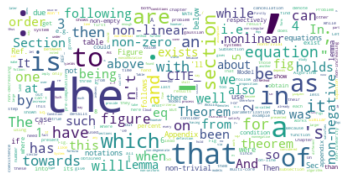

In [ ]:
wc = WordCloud(background_color="white", max_words=2000)
wc.generate_from_frequencies(freq)
print ("Word Cloud for Deleted Words")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
vocab = []
rows = df[df['Label']==1]
for _,row in rows.iterrows():
  try: 
    vocab.extend(row['ins_word'].split(' '))
  except:
    print(row['ins_word'])
    break
  #print(row['del_word'])
#wrds = [wrd for wrd in vocab if wrd != '']

In [ ]:
freq = list_to_dict(vocab)

In [ ]:
len(freq.keys())

19803

In [ ]:
frq2=sorted(freq.items(), key=lambda x: x[1], reverse=True)
frq2

Word Cloud for Instered Words


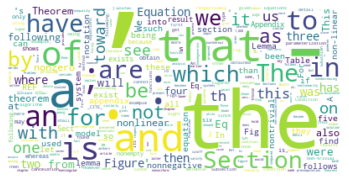

In [ ]:
wc = WordCloud(background_color="white", max_words=2000)
wc.generate_from_frequencies(freq)
print ("Word Cloud for Instered Words")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
vocab = []
rows = df[df['Label']==1]
for _,row in rows.iterrows():
  try:
    delw = row['del_word']
    insw = row['ins_word']
    both = delw + '' + insw
    both.strip()
    vocab.append(both)
  except:
    print(row['ins_word'])
    break
  #print(row['del_word'])
#wrds = [wrd for wrd in vocab if wrd != '']

In [ ]:
freq = list_to_dict(vocab)

In [ ]:
len(freq.keys())

70665

In [ ]:
frq2=sorted(freq.items(), key=lambda x: x[1], reverse=True)
frq2

[(',', 105367),
 (' -', 32446),
 ('the ', 20597),
 ('- ', 12854),
 (':', 11949),
 ('.', 8745),
 ('a ', 5932),
 (',,', 5817),
 ('that ', 4606),
 (',;', 3913),
 ('-', 2693),
 (':.', 2323),
 ('and ', 1806),
 (':,', 1794),
 ('sectionSection', 1704),
 (',:', 1441),
 ('.,', 1401),
 ('whichthat', 1299),
 ('isare', 1281),
 (' ,', 1276),
 ('aan', 1201),
 (',and ', 1192),
 ('.:', 1191),
 ('an ', 1166),
 ('of ', 1133),
 ("n'tnot", 1113),
 ('athe', 1103),
 (',.', 1099),
 ('thatwhich', 1083),
 ('thea', 1082),
 ("'s", 1076),
 ('areis', 1025),
 ('towardstoward', 976),
 (';,', 954),
 ('the ,', 949),
 (',the ', 922),
 ('it ', 901),
 ('to ', 836),
 ("'", 799),
 ('..', 795),
 ('-,', 776),
 ('is ', 757),
 ('th', 717),
 ('3three', 666),
 ('figureFigure', 617),
 ('ana', 595),
 ('2two', 594),
 ('non-linearnonlinear', 578),
 ('non-zerononzero', 574),
 ('in ', 545),
 ('as ', 541),
 ('equationEquation', 530),
 ('4four', 511),
 ('then ', 488),
 (', ', 484),
 (';', 478),
 ('for ', 471),
 ('eqEq', 459),
 ('Theorem

Word Cloud for Instered Words


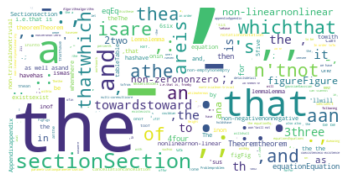

In [ ]:
wc = WordCloud(background_color="white", max_words=2000)
wc.generate_from_frequencies(freq)
print ("Word Cloud for del ins Words together")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

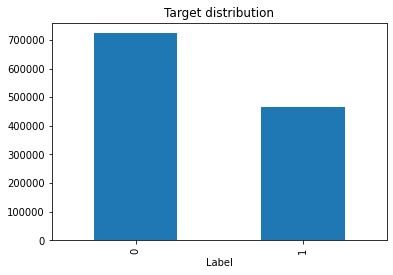

In [ ]:
plt.title('Target distribution')
df.groupby("Label")['SID'].count().plot.bar()

In [ ]:
print('edited sentences percentage:   {}%'.format(round((df['Label'].mean())*100, 2)))
print('not edited sentences percentage:   {}%'.format(100 - round((df['Label'].mean())*100, 2)))


edited sentences percentage:   39.24%
not edited sentences percentage:   60.76%


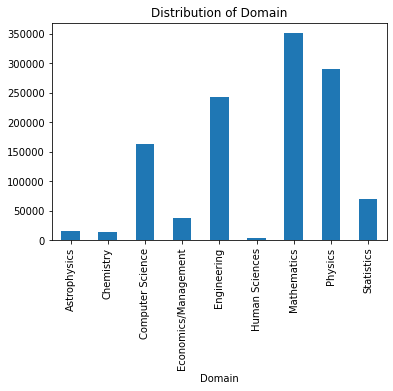

In [ ]:
plt.title('Distribution of Domain')
df.groupby("Domain")['SID'].count().plot.bar()

[Text(0, 0.5, 'count of sentence'), Text(0.5, 0, 'Lenght of sentence')]

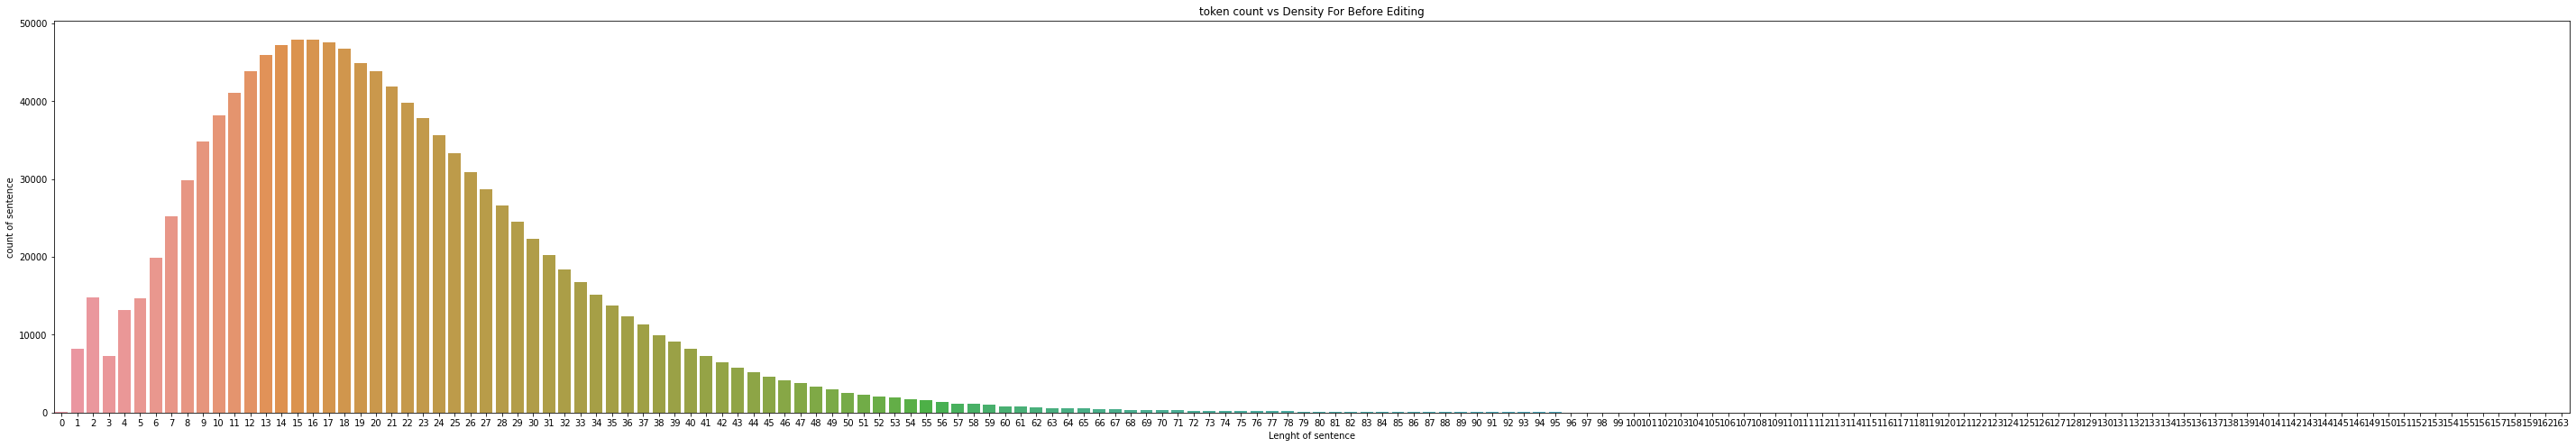

In [ ]:
plt.figure(figsize=(50, 8))

SBE = df['SBE'].str.split().apply(len).value_counts().sort_index()

SBE = SBE[SBE.index<np.percentile(SBE.index,90)]

plt.title('token count vs Density For Before Editing')
sns.barplot(x=SBE.index ,y=SBE.values,order = SBE.index).set(xlabel='Lenght of sentence', ylabel='count of sentence')

[Text(0, 0.5, 'count of sentence'), Text(0.5, 0, 'Lenght of sentence')]

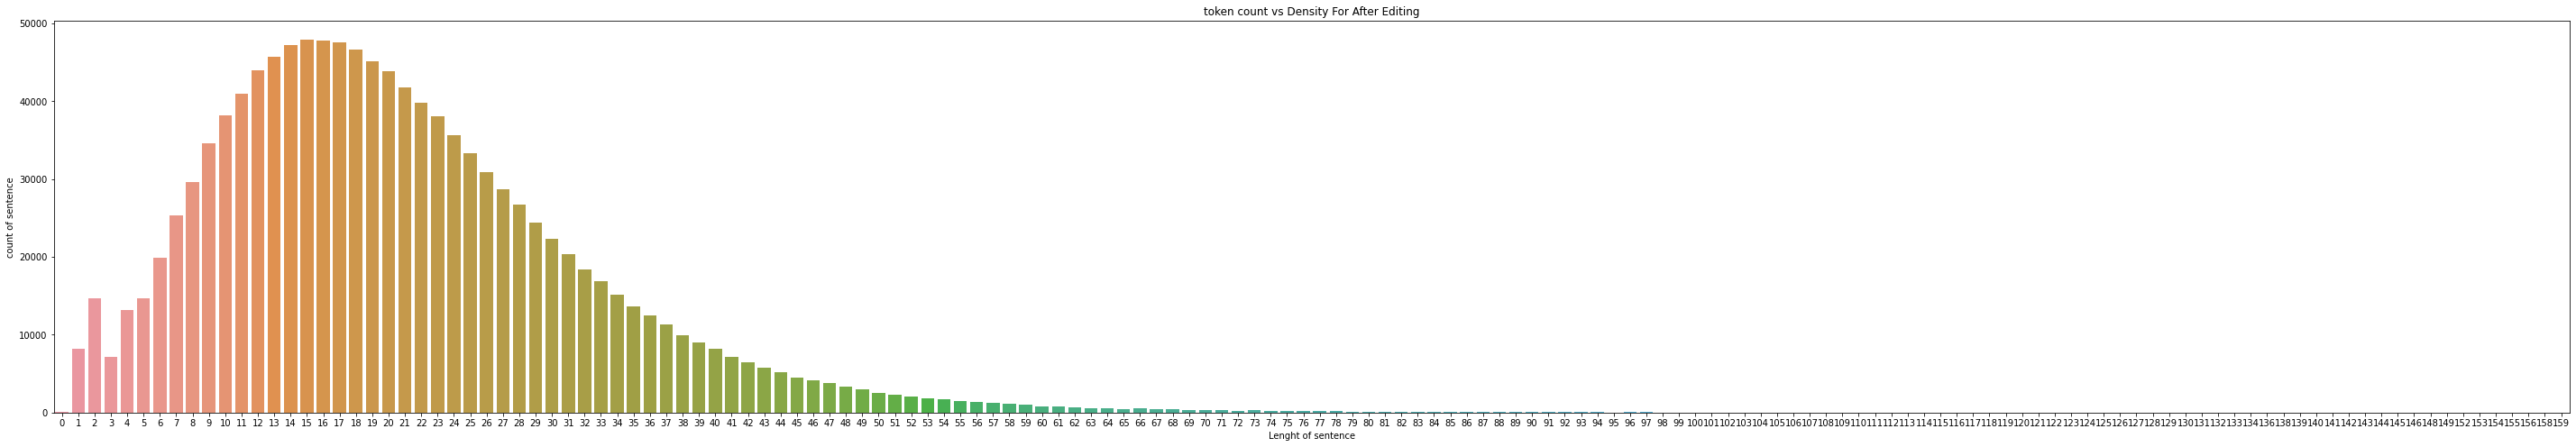

In [ ]:
plt.figure(figsize=(50, 8))

SBE = df['SAE'].str.split().apply(len).value_counts().sort_index()

SBE = SBE[SBE.index<np.percentile(SBE.index,90)]

plt.title('token count vs Density For After Editing')
sns.barplot(x=SBE.index ,y=SBE.values,order = SBE.index).set(xlabel='Lenght of sentence', ylabel='count of sentence')

In [ ]:
df['SBE_len'] = df['SBE'].str.len() 
df['SAE_len'] = df['SAE'].str.len()
df['SAE_n_words'] = df['SAE'].astype('str').apply(lambda row: len(row.split(" ")))
df['SBE_n_words'] = df['SBE'].astype('str').apply(lambda row: len(row.split(" ")))

In [ ]:
df

,SID,Domain,SBE,SAE,del_word,ins_word,Label,SBE_len,SAE_len,SAE_n_words,SBE_n_words
0,1.0,Physics,To facilitate an easier notation throughout th...,To facilitate an easier notation throughout th...,,",",1,225,227,35,36
1,1.1,Physics,Therefore _MATH_ defines a special order of ti...,Therefore _MATH_ defines a special order of ti...,,,0,109,109,21,21
2,1.2,Physics,This is important since only _MATH_ is the rea...,This is important since only _MATH_ is the rea...,,,0,127,127,22,22
3,1.3,Physics,Note that in all contour time-integrals we ess...,Note that in all contour time-integrals we ess...,,,0,77,77,11,11
4,2.0,Mathematics,Theorem _REF_ proves the equivalence of ensemb...,Theorem _REF_ proves the equivalence of ensemb...,,,0,51,51,8,8
...,...,...,...,...,...,...,...,...,...,...,...
1189407,254143.4,Computer Science,There are also personal Clouds that are built ...,There are also personal Clouds that are built ...,handheld,hand-held,1,146,147,24,24
1189408,254143.5,Computer Science,The inter-connection for the components in a p...,The interconnection for the components in a pe...,inter-connection,",",1,255,255,37,37
1189409,254144.0,Mathematics,Thus it appears that the perturbations of the ...,Thus it appears that the perturbations of the ...,,,0,130,130,23,23
1189410,254144.1,Mathematics,Since the speed of the soliton is not affected...,Since the speed of the soliton is not affected...,,",",1,183,184,33,33


In [ ]:
df.shape

(1189412, 11)

In [ ]:
# More features form quora question pair similarity
def more_features_from_QQPS(row:str):

  '''
  featurs = WordCommon, WordShare,WordTotal
  '''
  w1 = set(map(lambda word: word.lower().strip(), row['SAE'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['SBE'].split(" "))) 
  common = 1.0 * len(w1 & w2)
  total = 1.0 * (len(w1) + len(w2))
  share = 1.0 * common/total
  
  return common,total,share

In [ ]:
df['word_Common'],df['word_Total'],df['word_share'] = zip(*df.apply(more_features_from_QQPS,axis =1))

In [ ]:
df.head()

,SID,Domain,SBE,SAE,del_word,ins_word,Label,SBE_len,SAE_len,SAE_n_words,SBE_n_words,word_Common,word_Total,word_share
0,1.0,Physics,To facilitate an easier notation throughout th...,To facilitate an easier notation throughout th...,,",",1,225,227,35,36,25.0,57.0,0.438596
1,1.1,Physics,Therefore _MATH_ defines a special order of ti...,Therefore _MATH_ defines a special order of ti...,,,0,109,109,21,21,20.0,40.0,0.500000
2,1.2,Physics,This is important since only _MATH_ is the rea...,This is important since only _MATH_ is the rea...,,,0,127,127,22,22,19.0,38.0,0.500000
3,1.3,Physics,Note that in all contour time-integrals we ess...,Note that in all contour time-integrals we ess...,,,0,77,77,11,11,11.0,22.0,0.500000
4,2.0,Mathematics,Theorem _REF_ proves the equivalence of ensemb...,Theorem _REF_ proves the equivalence of ensemb...,,,0,51,51,8,8,8.0,16.0,0.500000


In [ ]:
df.shape

(1189412, 14)

In [ ]:
df.columns

Index(['SID', 'Domain', 'SBE', 'SAE', 'del_word', 'ins_word', 'Label',
       'SBE_len', 'SAE_len', 'SAE_n_words', 'SBE_n_words', 'word_Common',
       'word_Total', 'word_share'],
      dtype='object')

In [ ]:
print ("Minimum length of the SBE : " , min(df['SBE_n_words']))

print ("Minimum length of the questions in SAE : " , min(df['SAE_n_words']))

print ("Number of Questions with minimum length SBE :", df[df['SBE_n_words']== min(df['SBE_n_words'])].shape[0])
print ("Number of Questions with minimum length SAE :", df[df['SAE_n_words']== min(df['SAE_n_words'])].shape[0])

Minimum length of the SBE :  1
Minimum length of the questions in SAE :  1
Number of Questions with minimum length SBE : 1213
Number of Questions with minimum length SAE : 1183


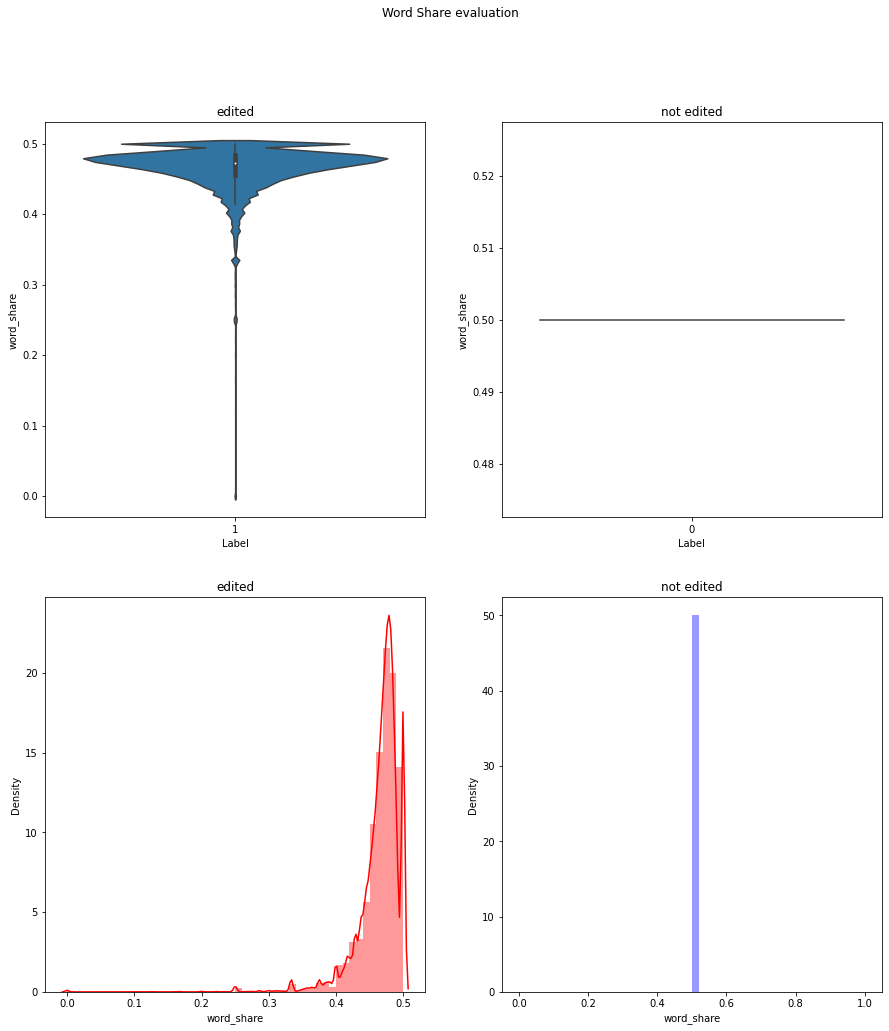

In [ ]:
plt.figure(figsize=(15, 16))
plt.suptitle('Word Share evaluation')
plt.subplot(2,2,1)
plt.title('edited')
sns.violinplot(x = 'Label', y = 'word_share', data = df[df['Label'] == 1])

plt.subplot(2,2,2)
plt.title('not edited')
sns.violinplot(x = 'Label', y = 'word_share', data = df[df['Label'] == 0])

plt.subplot(2,2,3)
plt.title('edited')
sns.distplot(df[df['Label'] == 1.0]['word_share'][0:] , label = "1", color = 'red')

plt.subplot(2,2,4)
plt.title('not edited')
sns.distplot(df[df['Label'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

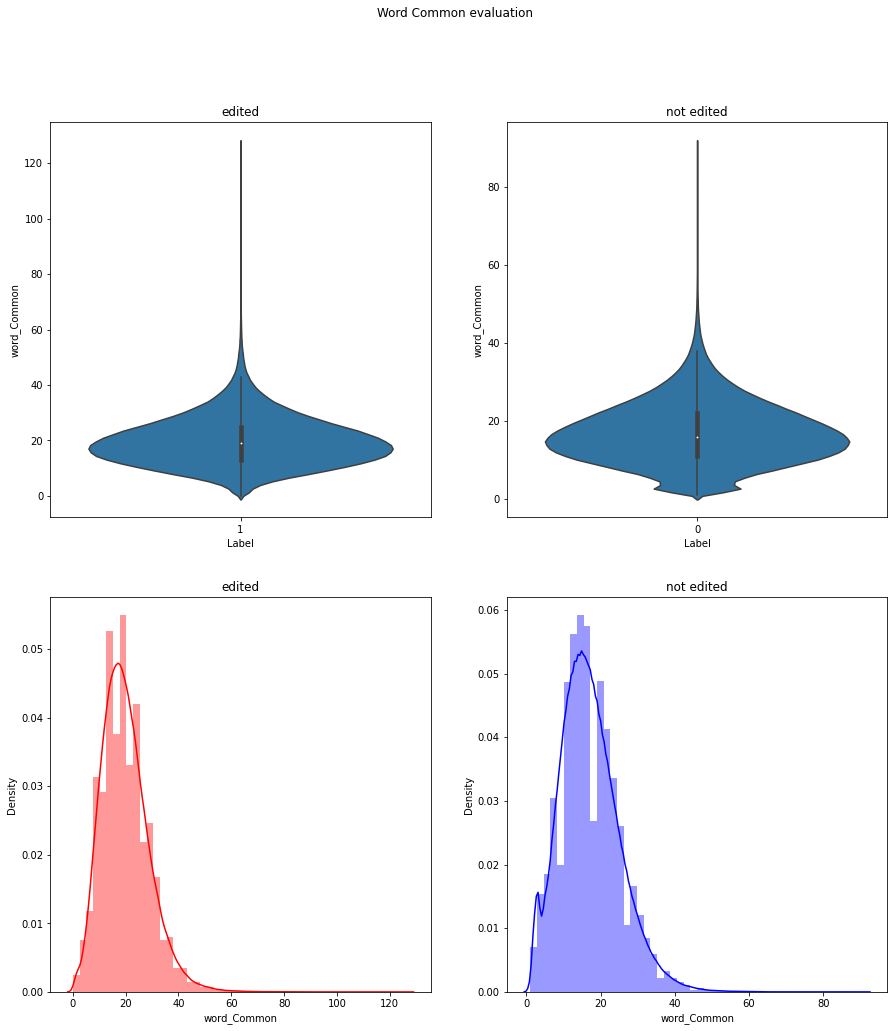

In [ ]:
plt.figure(figsize=(15, 16))
plt.suptitle('Word Common evaluation')

plt.subplot(2,2,1)
plt.title('edited')
sns.violinplot(x = 'Label', y = 'word_Common', data = df[df['Label'] == 1])

plt.subplot(2,2,2)
plt.title('not edited')
sns.violinplot(x = 'Label', y = 'word_Common', data = df[df['Label'] == 0])

plt.subplot(2,2,3)
plt.title('edited')
sns.distplot(df[df['Label'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')

plt.subplot(2,2,4)
plt.title('not edited')
sns.distplot(df[df['Label'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

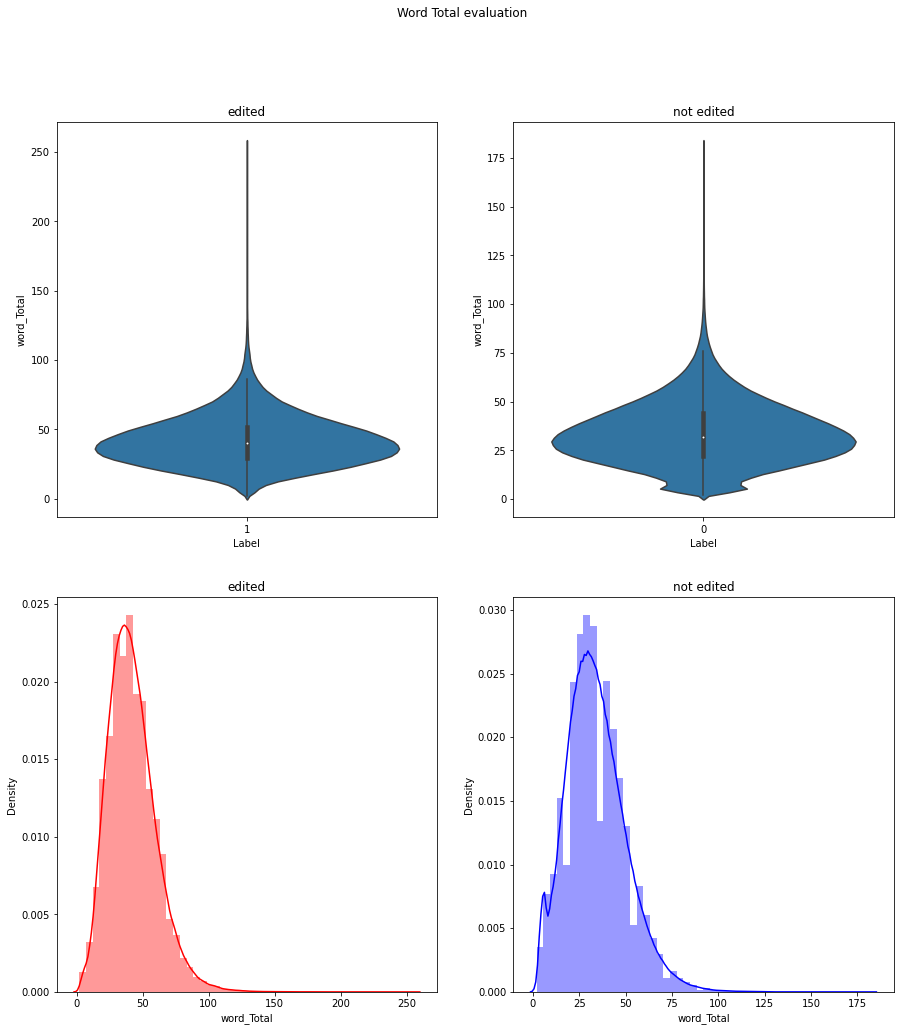

In [ ]:
plt.figure(figsize=(15, 16))
plt.suptitle('Word Total evaluation')

plt.subplot(2,2,1)
plt.title('edited')
sns.violinplot(x = 'Label', y = 'word_Total', data = df[df['Label'] == 1])

plt.subplot(2,2,2)
plt.title('not edited')
sns.violinplot(x = 'Label', y = 'word_Total', data = df[df['Label'] == 0])

plt.subplot(2,2,3)
plt.title('edited')
sns.distplot(df[df['Label'] == 1.0]['word_Total'][0:] , label = "1", color = 'red')

plt.subplot(2,2,4)
plt.title('not edited')
sns.distplot(df[df['Label'] == 0.0]['word_Total'][0:] , label = "0" , color = 'blue' )
plt.show()

###Using Fuzzywuzzy library for more EDA

In [ ]:
df['str_sim'] = df.apply(lambda row:  fuzz.ratio(row['SBE'],row['SAE']),axis=1)

In [ ]:
df['par_str_sim'] = df.apply(lambda row:  fuzz.partial_ratio(row['SBE'],row['SAE']),axis=1)

In [ ]:
df['tok_set_ratio'] = df.apply(lambda row:  fuzz.token_set_ratio(row['SBE'],row['SAE']),axis=1)

In [ ]:
df['tok_sort_ratio'] = df.apply(lambda row:  fuzz.token_sort_ratio(row['SBE'],row['SAE']),axis=1)

In [ ]:
df.shape

(1189412, 18)

In [ ]:
df.columns

Index(['SID', 'Domain', 'SBE', 'SAE', 'del_word', 'ins_word', 'Label',
       'SBE_len', 'SAE_len', 'SAE_n_words', 'SBE_n_words', 'word_Common',
       'word_Total', 'word_share', 'str_sim', 'par_str_sim', 'tok_set_ratio',
       'tok_sort_ratio'],
      dtype='object')

In [ ]:
df.to_csv(csvfile,index=False)

In [ ]:
df = pd.read_csv(csvfile)

In [ ]:
df.head()

,SID,Domain,SBE,SAE,del_word,ins_word,Label,SBE_len,SAE_len,SAE_n_words,SBE_n_words,word_Common,word_Total,word_share,str_sim,par_str_sim,tok_set_ratio,tok_sort_ratio
0,1.0,Physics,To facilitate an easier notation throughout th...,To facilitate an easier notation throughout th...,,",",1,225,227,35,36,25.0,57.0,0.438596,95,95,100,100
1,1.1,Physics,Therefore _MATH_ defines a special order of ti...,Therefore _MATH_ defines a special order of ti...,NaN,NaN,0,109,109,21,21,20.0,40.0,0.500000,100,100,100,100
2,1.2,Physics,This is important since only _MATH_ is the rea...,This is important since only _MATH_ is the rea...,NaN,NaN,0,127,127,22,22,19.0,38.0,0.500000,100,100,100,100
3,1.3,Physics,Note that in all contour time-integrals we ess...,Note that in all contour time-integrals we ess...,NaN,NaN,0,77,77,11,11,11.0,22.0,0.500000,100,100,100,100
4,2.0,Mathematics,Theorem _REF_ proves the equivalence of ensemb...,Theorem _REF_ proves the equivalence of ensemb...,NaN,NaN,0,51,51,8,8,8.0,16.0,0.500000,100,100,100,100


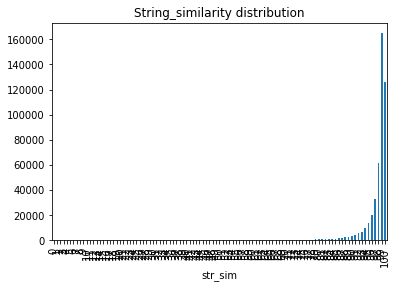

In [ ]:
plt.title('String_similarity distribution')
df[df['Label']==1].groupby('str_sim')['SID'].count().plot.bar()

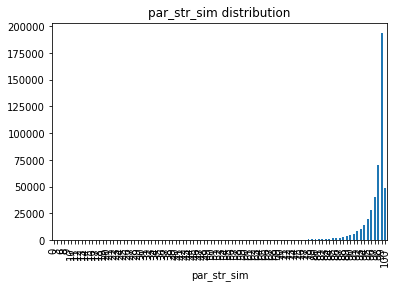

In [ ]:
plt.title('par_str_sim distribution')
df[df['Label']==1].groupby('par_str_sim')['SID'].count().plot.bar()

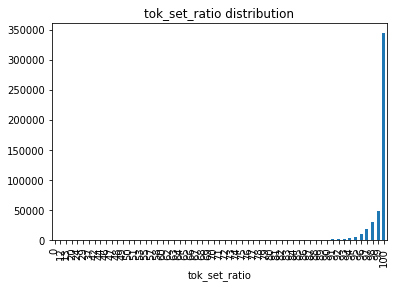

In [ ]:
plt.title('tok_set_ratio distribution')
df[df['Label']==1].groupby('tok_set_ratio')['SID'].count().plot.bar()

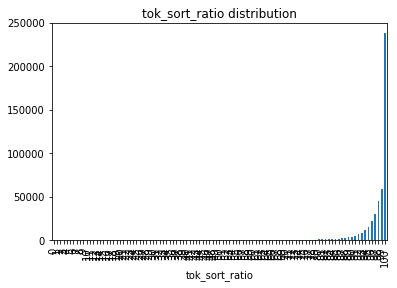

In [ ]:
plt.title('tok_sort_ratio distribution')
df[df['Label']==1].groupby('tok_sort_ratio')['SID'].count().plot.bar()